In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Background Information

47,213 rows city of Seattle Terry Stops Data.

Data set obtained from:
[Link](https://catalog.data.gov/dataset/terry-stops)

Data Columns Explanations:
[Link](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8)

## Seattle Census Data

**According to July 1, 2019 US Census Data**

Asian 15.4%

White Non-Hispanic 63.8%

Black 7.3%

Native American 0.5%

Hispanic 6.7%

Multi-Racial 6.9%

Pacific Islander 0.3%

Multi-Racial 6.9%

## Initial EDA and Visualizations

In [3]:
path = os.path.join(gparent, 'data/processed', 'cleaned1.csv')
df = pd.read_csv(path, keep_default_na=False)

In [4]:
df.head(2)

,Target,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,...,Precinct,Sector,Beat,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag
0,1,NA,Arrest,None,7500,1984,M,Black,Asian,Male,...,South,O,O2,0,2015,10,16,4,11,1
1,0,NA,Field Contact,None,5670,1965,M,White,NA,NA,...,NA,NA,NA,0,2015,3,19,3,7,0


## Proportion of Arrests by Race

In [5]:
# checking proportion of arrests by race
df[df['Stop Resolution'] == 'Arrest']['Subject Perceived Race'].value_counts(normalize=True)

White           0.472914
Black           0.335372
Unknown         0.050814
Asian           0.037292
Hispanic        0.034278
N_American      0.034019
NA              0.016622
Multi-Racial    0.013952
Other           0.003445
P_Islander      0.001292
Name: Subject Perceived Race, dtype: float64

## Proportion of Stops Ending in Arrest by Race

In [6]:
# checking proportion of arrests to stops by race
arate = df.groupby('Subject Perceived Race')['Target']\
           .value_counts(normalize=True)
arrest_rate = pd.DataFrame(arate)
arrest_rate.columns = ['Rate']
arrest_rate

Rate
Subject Perceived Race Target          
Asian                  0       0.715879
                       1       0.284121
Black                  0       0.721559
                       1       0.278441
Hispanic               0       0.760817
                       1       0.239183
Multi-Racial           0       0.797500
                       1       0.202500
NA                     0       0.896791
                       1       0.103209
N_American             0       0.707624
                       1       0.292376
Other                  0       0.736842
                       1       0.263158
P_Islander             0       0.732143
                       1       0.267857
Unknown                0       0.773686
                       1       0.226314
White                  0       0.760751
                       1       0.239249

## Visualizing Stop Resolutions by Race, Age & Gender

In [7]:
# making a list of the racial categories for visualization
races = df['Subject Perceived Race'].unique()

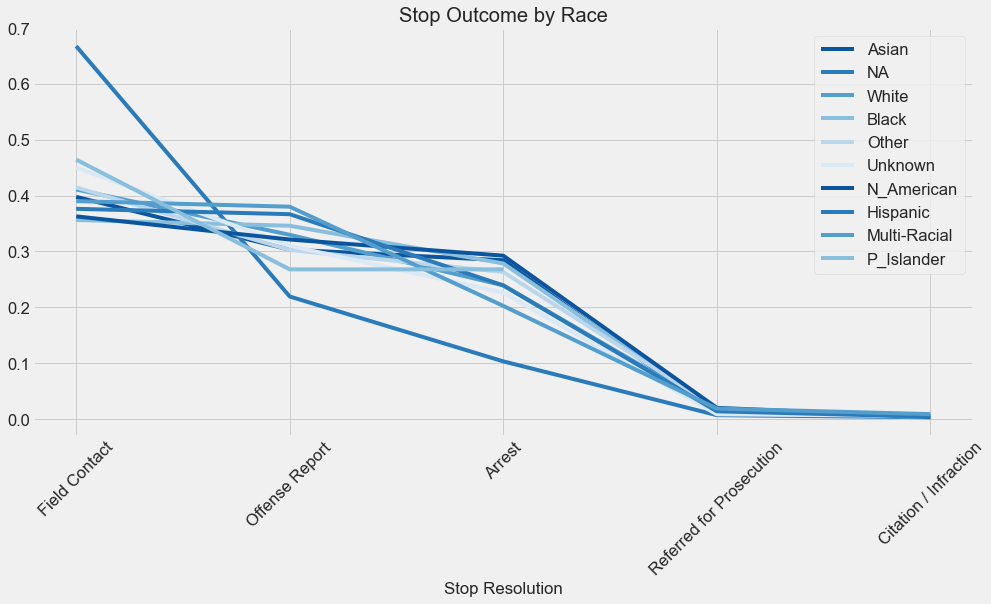

In [8]:
# checking outcomes by race
fig, axes=plt.subplots(figsize=(15,7))

for race in races:
    race_df = df.groupby('Subject Perceived Race')['Stop Resolution'].value_counts(normalize=True)[race]
    race_df.plot(label=f'{race}')
plt.title('Stop Outcome by Race')    
plt.xticks(np.arange(5), ['Field Contact','Offense Report',\
                          'Arrest', 'Referred for Prosecution',\
                         'Citation / Infraction'], rotation=45)
plt.legend()
plt.show()

In [9]:
excluded = ['NA', 'Other', 'Unknown','Multi-Racial', 'P_Islander']
new_race_list = [x for x in races if x not in excluded]

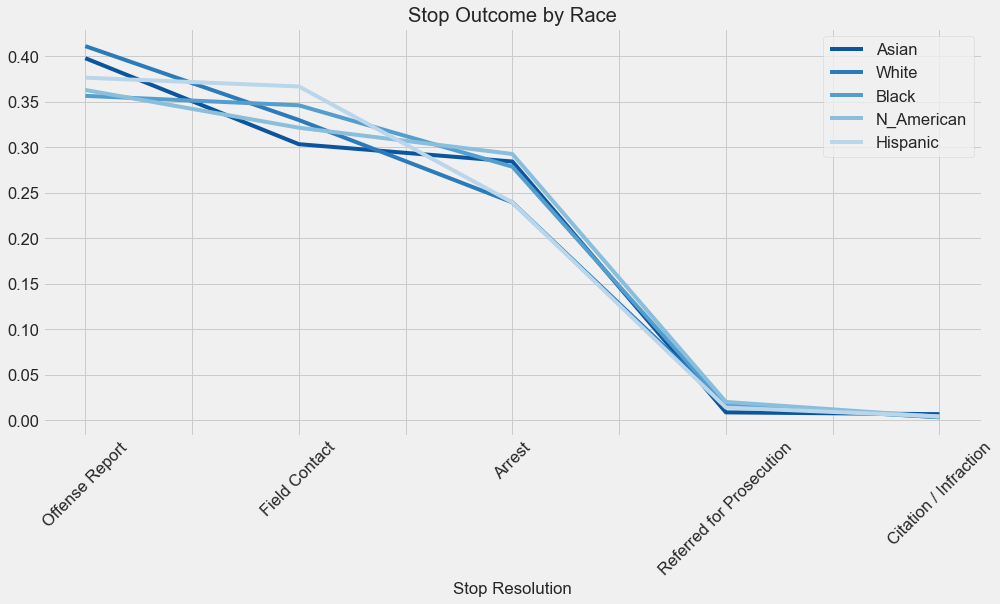

In [10]:
# checking outcomes by race
fig, axes=plt.subplots(figsize=(15,7))

for race in new_race_list:
    race_df = df.groupby('Subject Perceived Race')['Stop Resolution'].value_counts(normalize=True)[race]
    race_df.plot(label=f'{race}')
plt.title('Stop Outcome by Race')    
plt.xticks(rotation=45)
plt.legend()
plt.show()

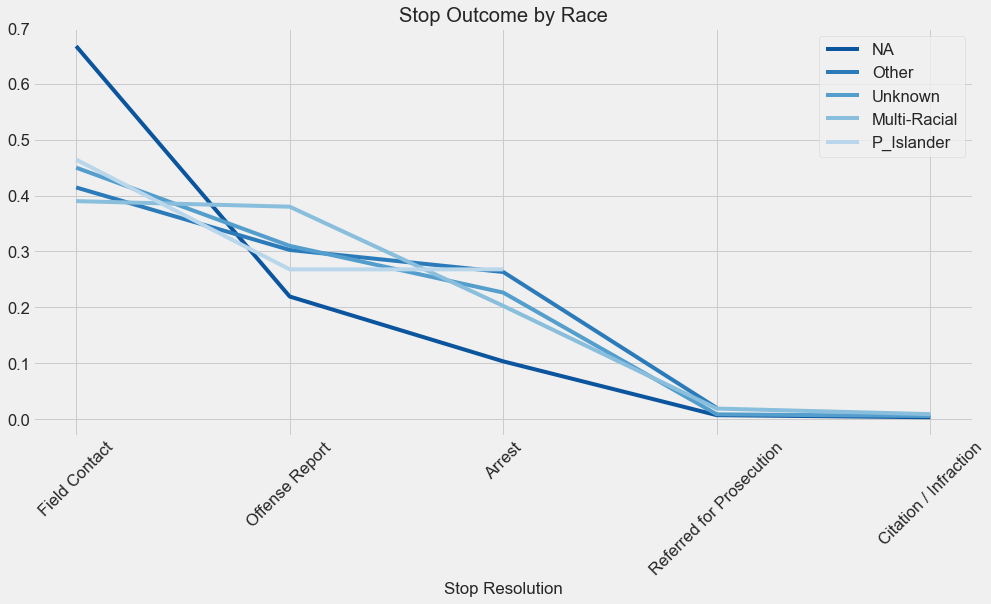

In [11]:
# checking outcomes by race
fig, axes=plt.subplots(figsize=(15,7))

for race in excluded:
    race_df = df.groupby('Subject Perceived Race')['Stop Resolution'].value_counts(normalize=True)[race]
    race_df.plot(label=f'{race}')
plt.title('Stop Outcome by Race')    
plt.xticks(np.arange(5), ['Field Contact','Offense Report',\
                          'Arrest', 'Referred for Prosecution',\
                         'Citation / Infraction'], rotation=45)
plt.legend()
plt.show()

In [12]:
#  getting age list
ages = df['Subject Age Group'].unique()

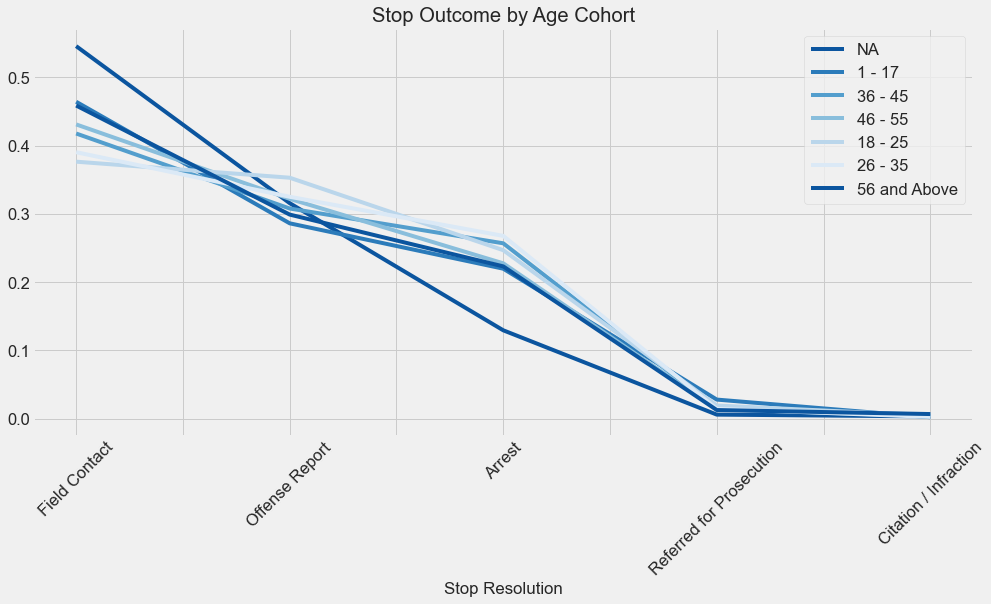

In [13]:
# checking outcomes by age category
fig, axes=plt.subplots(figsize=(15,7))

for age in ages:
    age_df = df.groupby('Subject Age Group')['Stop Resolution'].value_counts(normalize=True)[age]
    age_df.plot(label=f'{age}')
plt.title('Stop Outcome by Age Cohort')    
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [14]:
# getting gender list
genders = df['Subject Perceived Gender'].unique()

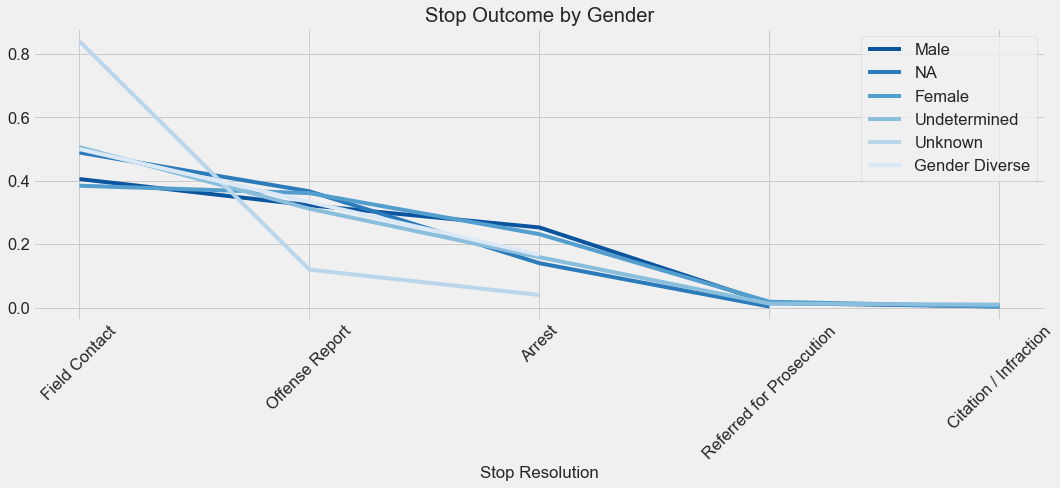

In [15]:
# checking outcome by gender
fig, axes=plt.subplots(figsize=(15,7))

for g in genders:
    age_df = df.groupby('Subject Perceived Gender')\
    ['Stop Resolution'].value_counts(normalize=True)[g]
    age_df.plot(label=f'{g}')
plt.title('Stop Outcome by Gender')    
plt.xticks(np.arange(5), ['Field Contact','Offense Report',\
                          'Arrest', 'Referred for Prosecution',\
                         'Citation / Infraction'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# checking proprtion of indeterminate race category
unknown = df['Subject Perceived Race'].value_counts()[2]
na = df['Subject Perceived Race'].value_counts()[3]

(unknown + na)/df['Subject Perceived Race'].value_counts().sum()

0.09533645655877343

## Visualizing the Target Feature

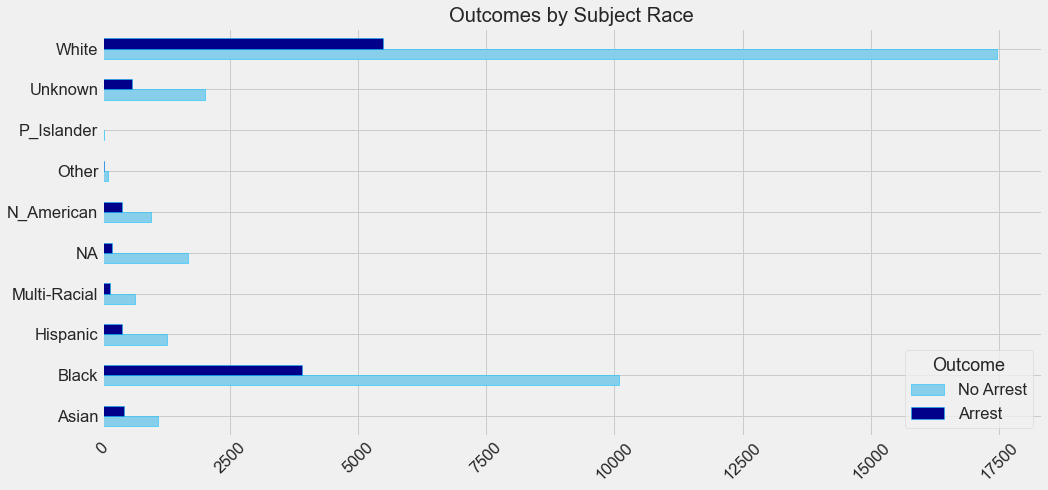

In [17]:
# getting normalized target value counts by race for visualization
target_race = df.groupby('Subject Perceived Race')['Target'].value_counts().unstack()

# visualizing target values by race
target_race.plot(kind='barh', figsize=(15,7), color=['skyblue', 'darkblue'], edgecolor='deepskyblue')
plt.title('Outcomes by Subject Race')
plt.xticks(rotation=45)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.ylabel("")
plt.show()

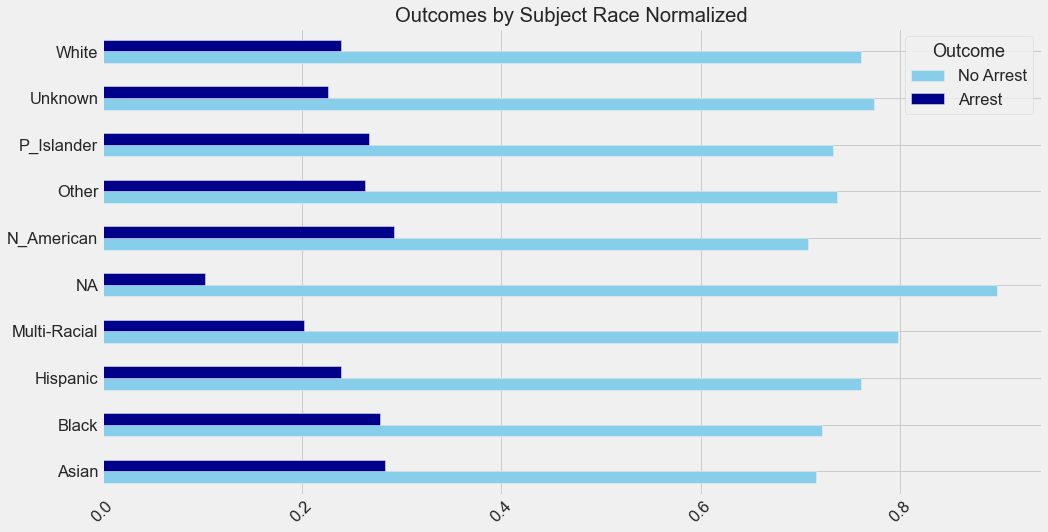

In [18]:
# getting target value counts by race for visualization
target_race = df.groupby('Subject Perceived Race')\
                        ['Target'].value_counts(normalize=True).unstack()

# visualizing target values by race
target_race.plot(kind='barh', figsize=(15,8), color=['skyblue', 'darkblue'])
plt.title('Outcomes by Subject Race Normalized')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

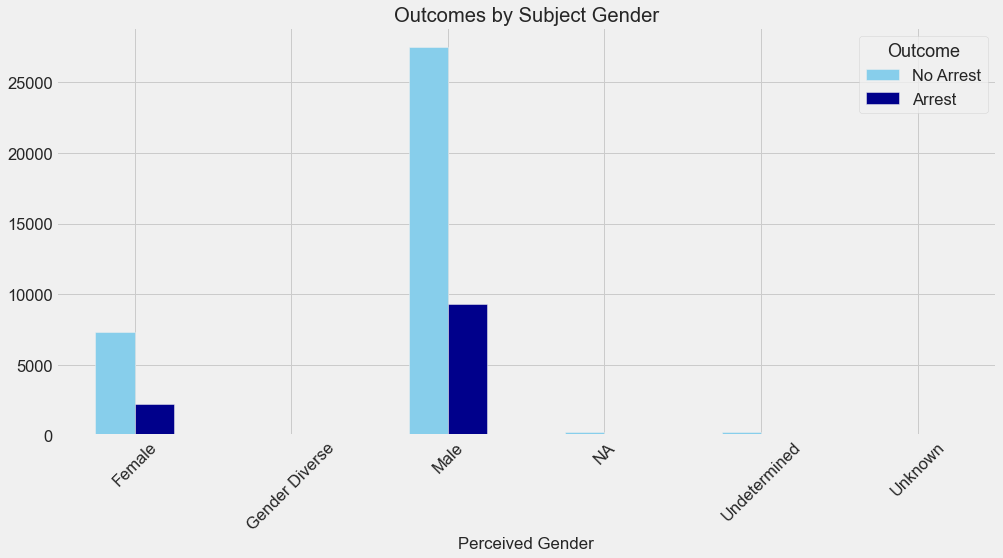

In [19]:
#  getting target value counts by gender
target_gender = df.groupby('Subject Perceived Gender')['Target'].value_counts().unstack()

# visualizing target values by gender
target_gender.plot(kind='bar', figsize=(15,7), color=['skyblue', 'darkblue'])
plt.title('Outcomes by Subject Gender')                                                 
plt.xlabel('Perceived Gender')
plt.xticks(rotation=45)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

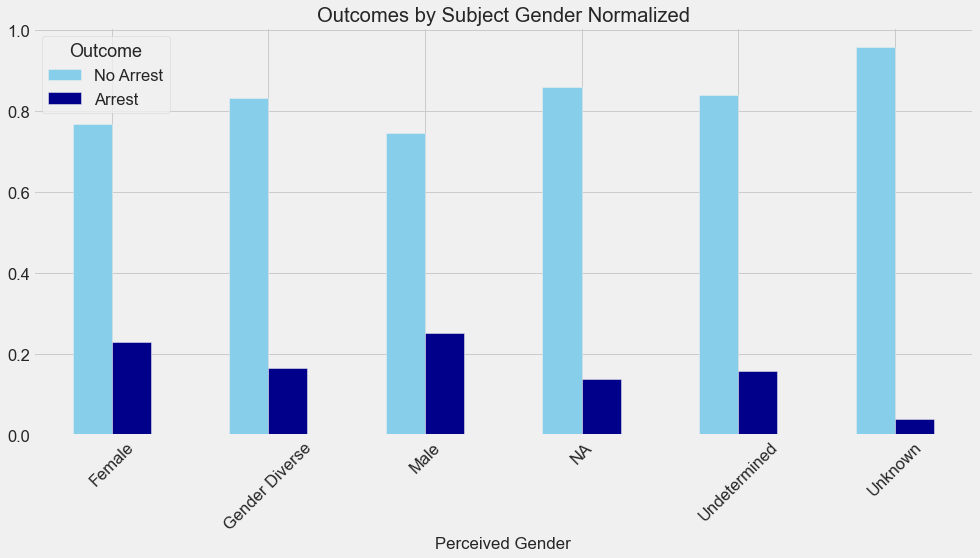

In [20]:
#  getting target value counts by gender
target_gender = df.groupby('Subject Perceived Gender')\
['Target'].value_counts(normalize=True).unstack()

# visualizing target values by gender
target_gender.plot(kind='bar', figsize=(15,7), color=['skyblue', 'darkblue'])
plt.title('Outcomes by Subject Gender Normalized')                                                 
plt.xlabel('Perceived Gender')
plt.xticks(rotation=45)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

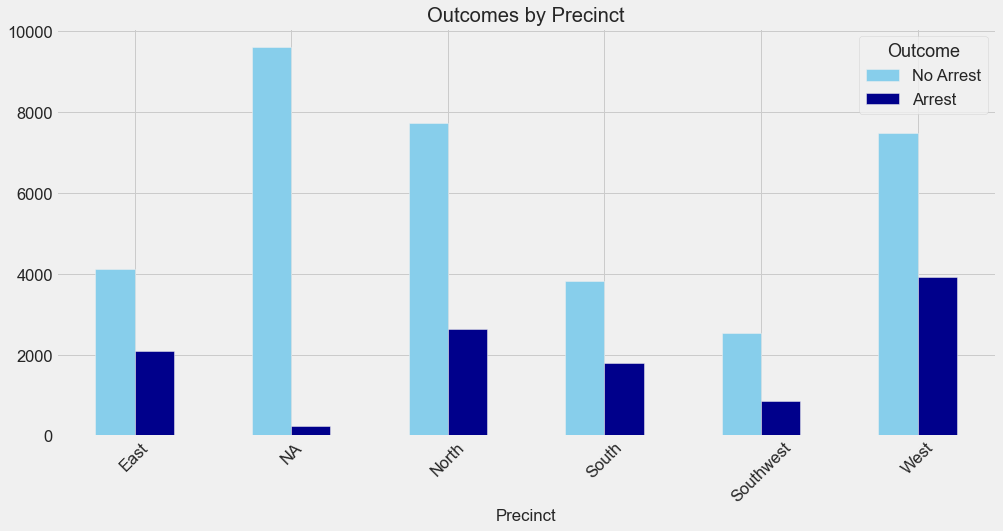

In [21]:
# getting target value counts by precinct
precinct_target = df.groupby('Precinct')['Target'].value_counts().unstack()

precinct_target.plot(kind='bar', figsize=(15,7), color=['skyblue', 'darkblue'])
plt.title('Outcomes by Precinct')
plt.xlabel('Precinct')
plt.xticks(rotation=45)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

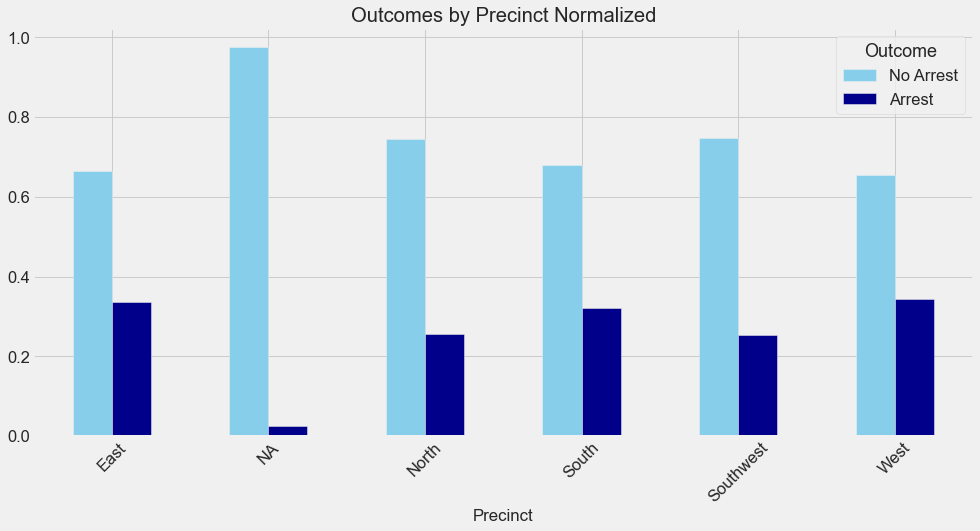

In [22]:
# getting target value counts by precinct
precinct_target = df.groupby('Precinct')['Target'].value_counts(normalize=True).unstack()

precinct_target.plot(kind='bar', figsize=(15,7), color=['skyblue', 'darkblue'])
plt.title('Outcomes by Precinct Normalized')
plt.xlabel('Precinct')
plt.xticks(rotation=45)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

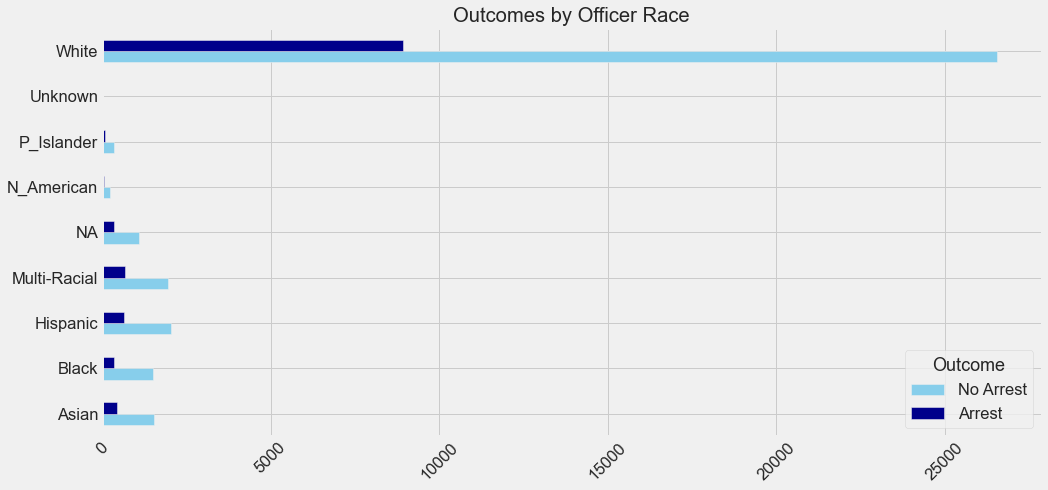

In [23]:
# getting target value counts by officer race
officer_races = df.groupby('Officer Race')['Target'].value_counts().unstack()

officer_races.plot(kind='barh', figsize=(15,7), color=['skyblue', 'darkblue'])
plt.title('Outcomes by Officer Race')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

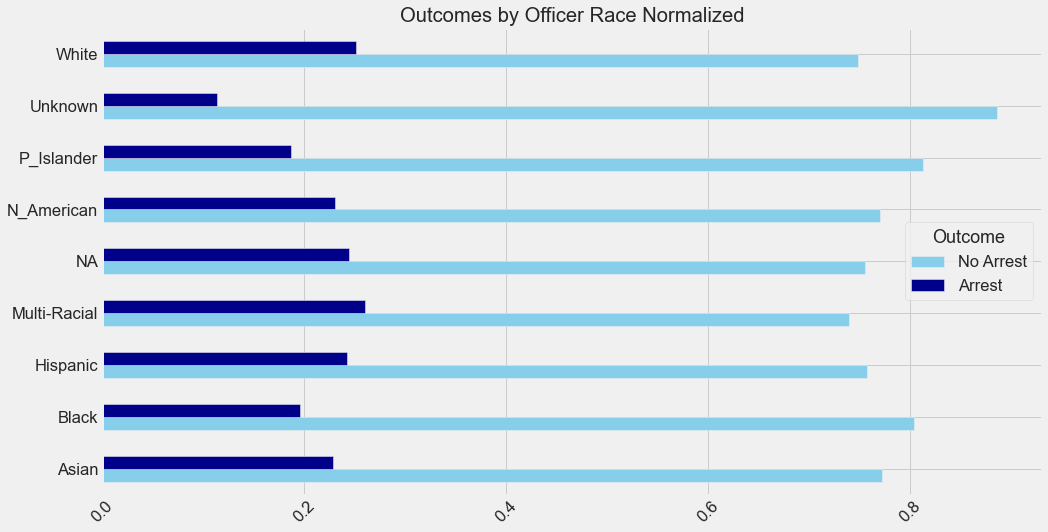

In [24]:
officer_races = df.groupby('Officer Race')['Target'].value_counts(normalize=True).unstack()

officer_races.plot(kind='barh', figsize=(15,8), color=['skyblue', 'darkblue'])

plt.title('Outcomes by Officer Race Normalized')
plt.xlabel('Officer Race')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
# plt.legend(title='Target',bbox_to_anchor= (1.03, 1))
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

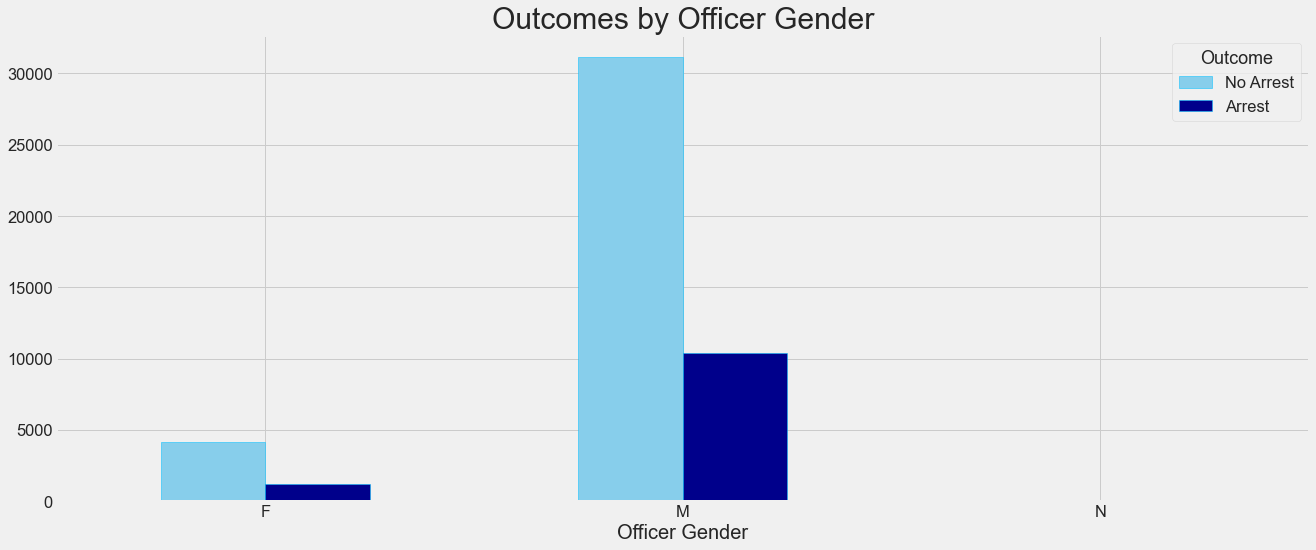

In [25]:
officer_gender = df.groupby('Officer Gender')['Target'].value_counts().unstack()

officer_gender.plot(kind='bar', figsize=(20,8), color=['skyblue', 'darkblue'], edgecolor='deepskyblue')
plt.title('Outcomes by Officer Gender', fontsize=30)
plt.xlabel('Officer Gender', fontsize=20)
plt.xticks(rotation=0)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

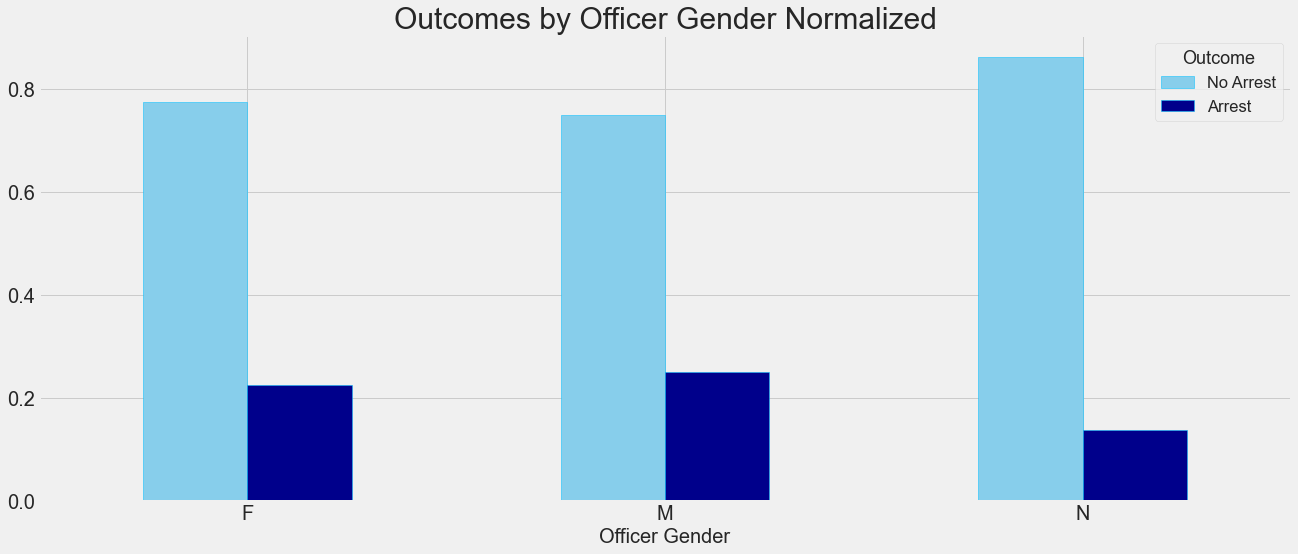

In [26]:
officer_gender = df.groupby('Officer Gender')['Target'].value_counts(normalize=True).unstack()

ax = officer_gender.plot(kind='bar', figsize=(20,8), color=['skyblue', 'darkblue'], edgecolor='deepskyblue')
plt.title('Outcomes by Officer Gender Normalized', fontsize=30)
ax.tick_params(labelsize=20)
plt.xticks(rotation=0)
plt.xlabel('Officer Gender', fontsize=20)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

## Visualizing the Target by Beat

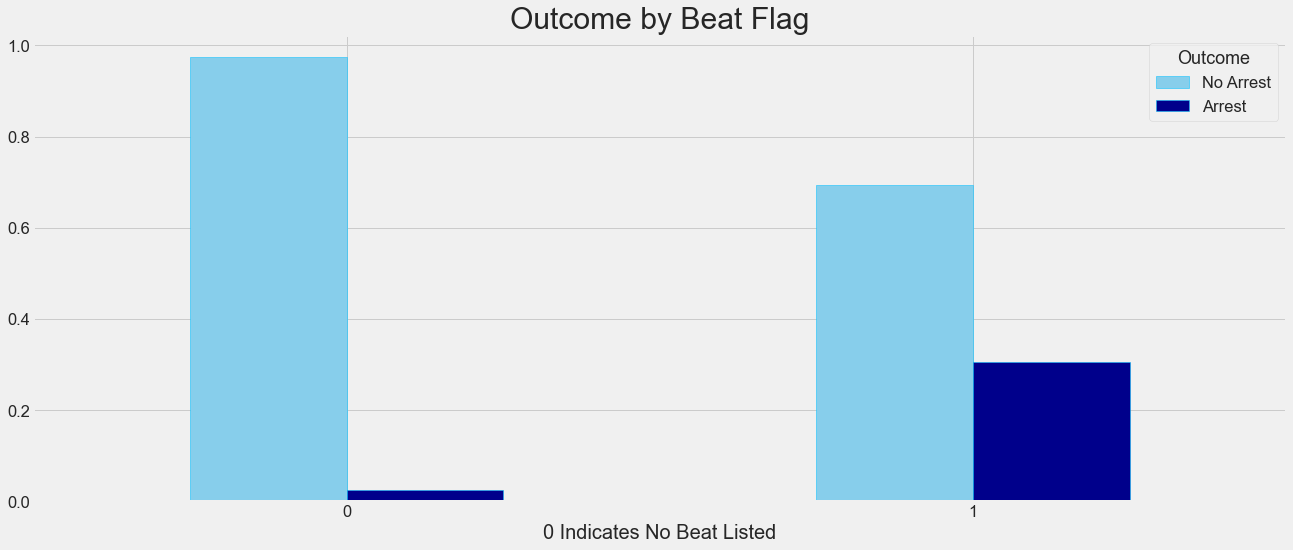

In [27]:
bdf = df.groupby('Beat Flag')['Target'].value_counts(normalize=True).unstack()
bdf.plot(kind='bar', figsize=(20,8), color=['skyblue', 'darkblue'], edgecolor='deepskyblue')

plt.xticks(rotation=0)
plt.title('Outcome by Beat Flag', fontsize=30)
plt.xlabel('0 Indicates No Beat Listed', fontsize=20)
plt.legend(title='Outcome', labels=['No Arrest', 'Arrest'])
plt.show()

## Visualizing the Rate of Weapons Found

In [28]:
# creating a weapons by race data frame
wdf = pd.DataFrame(df.groupby('Subject Perceived Race')['Weapon Flag'].value_counts())

# calculating the weapons found rate by race
hit_rates = []
for race in races:
    hits = wdf.loc[race]['Weapon Flag'][1]   #number of people in the racial group found with a weapon
    #total number in the racial group stopped
    total = df[df['Subject Perceived Race']\
               == race].value_counts().sum() 
    rate = hits/total
    hit_rates.append([race, rate])

#  calculating the meat weapons found rate
mean_hit_rate = np.array([hit_rates[i][1] for i in range(len(hit_rates))]).mean()

# creating a hit rate data frame and visualization
hr_df = pd.DataFrame(hit_rates, columns = ['Race', 'Hit Rate']).sort_values(by='Hit Rate', ascending=False)

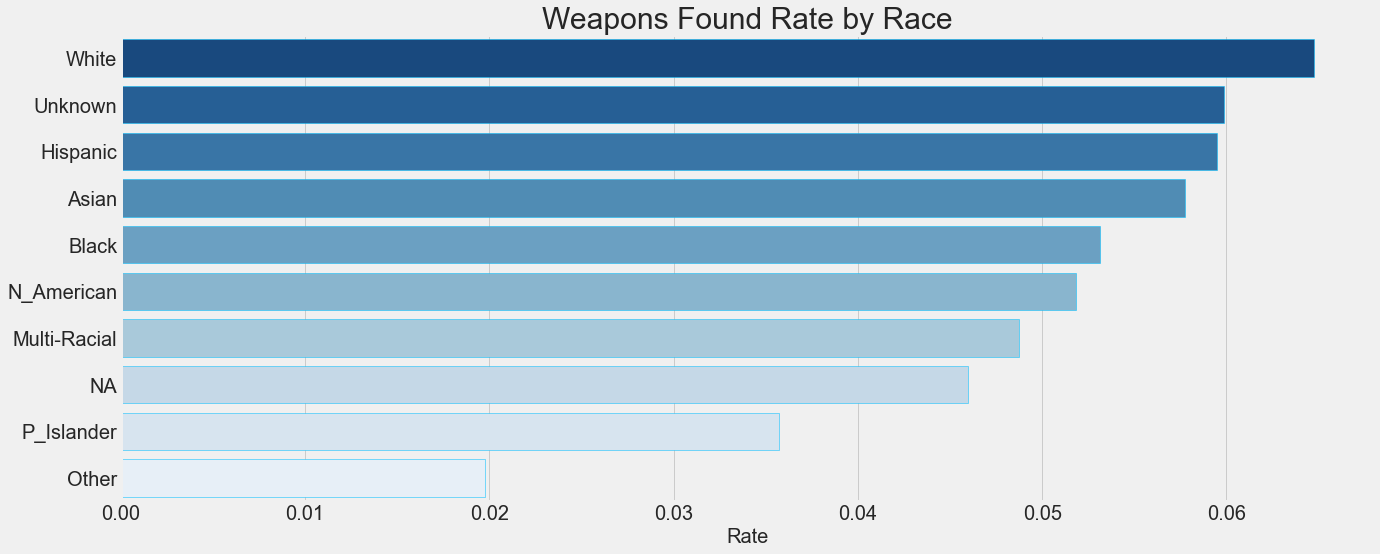

In [29]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(y='Race', x='Hit Rate', data=hr_df, palette='Blues_r', edgecolor='deepskyblue')
plt.title('Weapons Found Rate by Race', fontsize=30)
ax.tick_params(labelsize=20)
plt.ylabel("")
plt.xlabel('Rate', fontsize=20)
plt.show()

In [30]:
print(f'Mean Weapon Found Rate: {mean_hit_rate}')
hit_rates

Mean Weapon Found Rate: 0.049695575981592514


[['Asian', 0.05774278215223097],
 ['NA', 0.045989304812834225],
 ['White', 0.06474663413358896],
 ['Black', 0.0531283518055059],
 ['Other', 0.019736842105263157],
 ['Unknown', 0.05983889528193326],
 ['N_American', 0.05181347150259067],
 ['Hispanic', 0.059495192307692304],
 ['Multi-Racial', 0.04875],
 ['P_Islander', 0.03571428571428571]]

## Visualizing the Arrest Rates by Race

In [31]:
# creating an arrest rate data frame and visualization
arrest_rates = df[df['Target']==1]['Subject Perceived Race'].value_counts(normalize=True)

adf = pd.DataFrame(arrest_rates)
adf.reset_index(inplace=True)
adf.columns = ['Race', 'Arrest Rate']

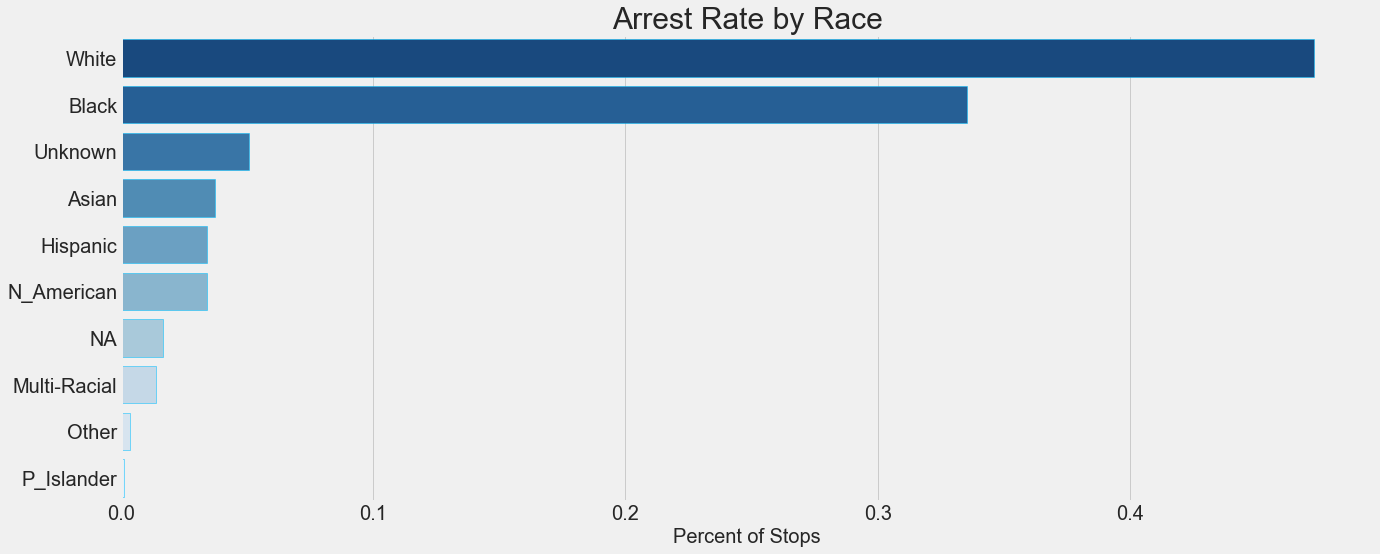

In [32]:
fig, ax = plt.subplots(figsize =(20, 8))
sns.barplot(x='Arrest Rate', y='Race', data=adf, edgecolor='deepskyblue', palette='Blues_r')
plt.title('Arrest Rate by Race', fontsize=30)
ax.tick_params(labelsize=20)
plt.xlabel('Percent of Stops', fontsize=20)
plt.ylabel("")
plt.show()

In [33]:
# mean arrest rate & arrest rates by race
mean_arrest_rate = adf['Arrest Rate'].mean()
print(f'Mean Arrest Rate: {round(mean_arrest_rate, 2)}')
round(arrest_rates, 3)

Mean Arrest Rate: 0.1


White           0.473
Black           0.335
Unknown         0.051
Asian           0.037
Hispanic        0.034
N_American      0.034
NA              0.017
Multi-Racial    0.014
Other           0.003
P_Islander      0.001
Name: Subject Perceived Race, dtype: float64

## Visualizing the Proportion of Terry Stops by Race

In [34]:
# proportion of terry stops by race
stop_percent = df['Subject Perceived Race'].value_counts('normalize=True')

sdf = pd.DataFrame(stop_percent)
sdf.reset_index(inplace=True)
sdf.columns = ['Race', 'Percentage']

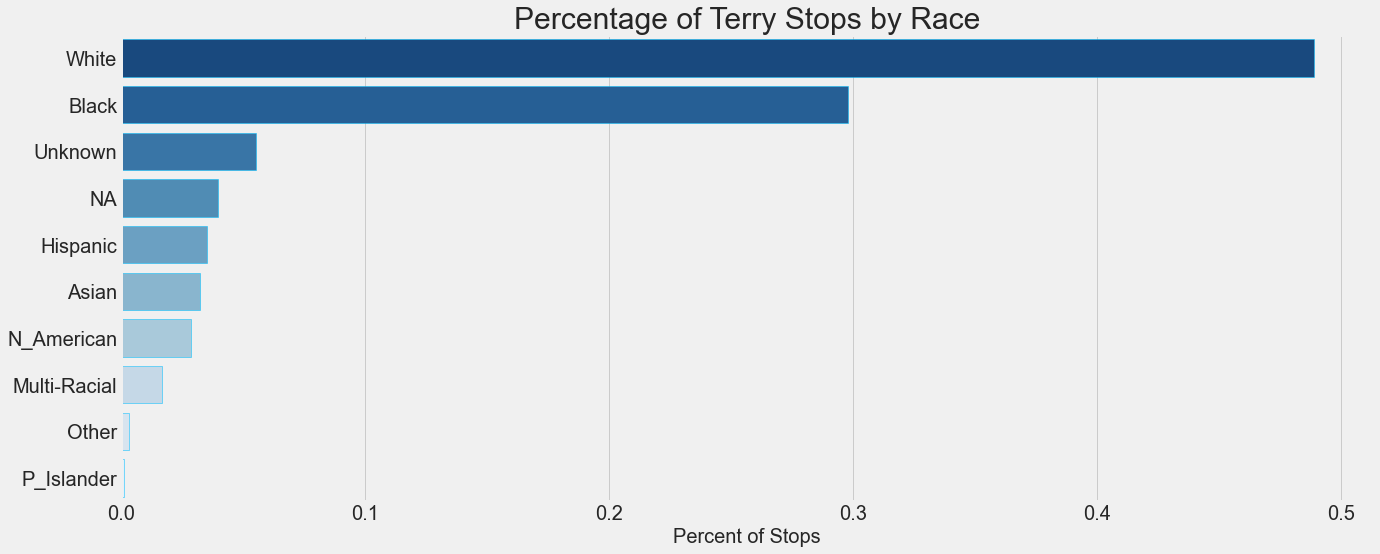

In [35]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='Percentage', y='Race', edgecolor='deepskyblue', palette='Blues_r', data=sdf)
ax.tick_params(labelsize=20)
plt.title('Percentage of Terry Stops by Race', fontsize=30)
plt.xlabel('Percent of Stops', fontsize=20)
plt.ylabel("")
plt.show()

## Visualizing Officers With Most Arrests

In [36]:
# checking out arrests by officer id
arrests = df[df['Target']==1]
oid = arrests.groupby('Officer ID')['Target'].value_counts()
officer_df = pd.DataFrame(oid)
officer_df.columns = ['Arrests']
officer_df = officer_df.reset_index()
top20 = officer_df.drop('Target', axis=1).sort_values(by='Arrests', ascending=False)[:20]

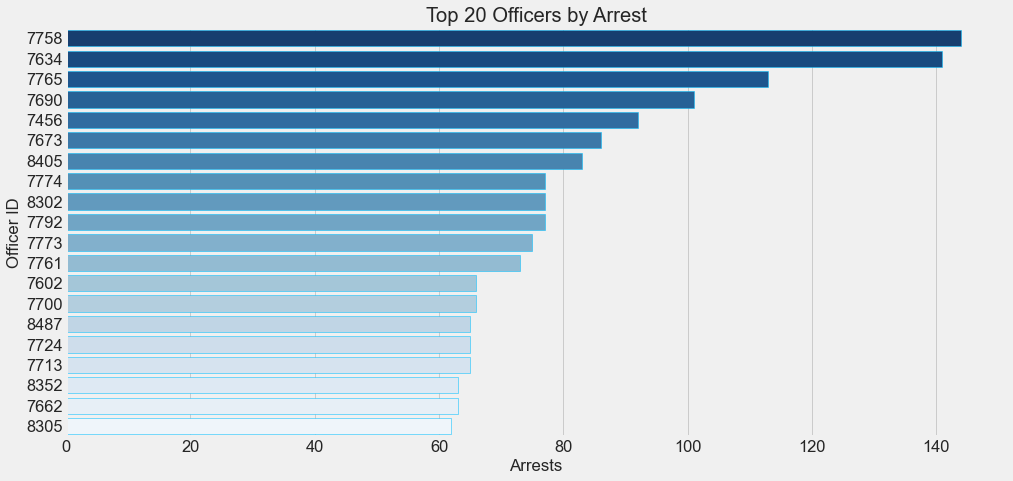

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x='Arrests', y='Officer ID', edgecolor='deepskyblue', palette='Blues_r', data=top20)
plt.title('Top 20 Officers by Arrest')
plt.show()

In [38]:
# top 20 officers by arrest
top20

,Officer ID,Arrests
523,7758,144
418,7634,141
528,7765,113
462,7690,101
308,7456,92
449,7673,86
666,8405,83
535,7774,77
570,8302,77
552,7792,77
